### RAG LLM Evaluation Metrics

ScienceSage RAG LLM Evaluation Metrics

This notebook computes and visualizes key retrieval metrics for your RAG pipeline:
- Precision@k
- Recall@k
- Mean Reciprocal Rank (MRR)
- Normalized Discounted Cumulative Gain (nDCG)
- Contextual Recall and Sufficiency

In [ ]:
import json
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

sys.path.append("../sciencesage")
from sciencesage.config import GROUND_TRUTH_FILE, EVAL_RESULTS_FILE, TOP_K, METRICS_SUMMARY_FILE

2025-09-25 22:26:27.063 | INFO     | sciencesage.config:<module>:89 - Configuration loaded.


In [ ]:
def load_jsonl(path):
    with open(path) as f:
        return [json.loads(line) for line in f if line.strip()]

ground_truth = load_jsonl("../" + GROUND_TRUTH_FILE)
results = load_jsonl("../" + EVAL_RESULTS_FILE)

In [ ]:
ground_truth_df = pd.DataFrame(ground_truth)
results_df = pd.DataFrame(results)

In [4]:
def precision_at_k(retrieved, relevant, k):
    retrieved_k = retrieved[:k]
    relevant_set = set(relevant)
    return len([chunk for chunk in retrieved_k if chunk in relevant_set]) / k


In [5]:
def recall_at_k(retrieved, relevant, k):
    retrieved_k = retrieved[:k]
    relevant_set = set(relevant)
    return len([chunk for chunk in retrieved_k if chunk in relevant_set]) / len(relevant_set) if relevant_set else 0.0

In [6]:
def reciprocal_rank(retrieved, relevant):
    for idx, chunk in enumerate(retrieved, 1):
        if chunk in relevant:
            return 1.0 / idx
    return 0.0

In [7]:
def dcg(retrieved, relevant, k):
    dcg_val = 0.0
    for i, chunk in enumerate(retrieved[:k]):
        rel = 1 if chunk in relevant else 0
        dcg_val += rel / np.log2(i + 2)
    return dcg_val

In [8]:
def ndcg_at_k(retrieved, relevant, k):
    ideal_rels = [1] * min(len(relevant), k)
    ideal_dcg = sum([rel / np.log2(i + 2) for i, rel in enumerate(ideal_rels)])
    if ideal_dcg == 0:
        return 0.0
    return dcg(retrieved, relevant, k) / ideal_dcg

In [9]:
# Contextual Recall and Sufficiency: For demo, treat as recall@k (customize as needed)
def contextual_recall_and_sufficiency(retrieved, relevant, k):
    # Placeholder: in practice, this may require human or LLM judgment
    return recall_at_k(retrieved, relevant, k)

### Compute Metrics for All Queries

In [ ]:
metrics = []
for g, r in zip(ground_truth, results):
    retrieved = r.get("retrieved_chunks", [])
    relevant = g.get("ground_truth_chunks", [])
    metrics.append({
        "query": g.get("query", ""),
        f"precision@{TOP_K}": precision_at_k(retrieved, relevant, TOP_K),
        f"recall@{TOP_K}": recall_at_k(retrieved, relevant, TOP_K),
        "MRR": reciprocal_rank(retrieved, relevant),
        "nDCG": ndcg_at_k(retrieved, relevant, TOP_K),
        "contextual_recall_sufficiency": contextual_recall_and_sufficiency(retrieved, relevant, TOP_K)
    })

metrics_df = pd.DataFrame(metrics)

In [11]:
metrics_df.head()

,query,precision@5,recall@5,MRR,nDCG,contextual_recall_sufficiency
0,What is the purpose of the Mars-Grunt mission?,0.0,0.0,0.0,0.0,0.0
1,What are the three distinct phases outlined in...,0.0,0.0,0.0,0.0,0.0
2,What are some alternate theories for the creat...,0.0,0.0,0.0,0.0,0.0
3,How does CO2 ice accumulation contribute to gu...,0.0,0.0,0.0,0.0,0.0
4,Which space probe was the first to explore Nep...,0.0,0.0,0.0,0.0,0.0


In [12]:
agg_metrics = metrics_df.mean(numeric_only=True)
print("Average Metrics:")
display(agg_metrics)

Average Metrics:


precision@5                      0.0
recall@5                         0.0
MRR                              0.0
nDCG                             0.0
contextual_recall_sufficiency    0.0
dtype: float64

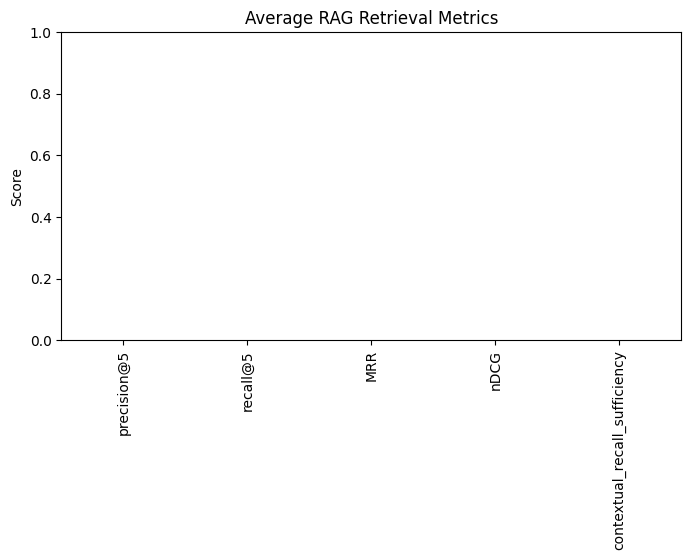

In [13]:
# Bar plot of average metrics
agg_metrics.plot(kind="bar", figsize=(8,4), ylim=(0,1), title="Average RAG Retrieval Metrics")
plt.ylabel("Score")
plt.show()

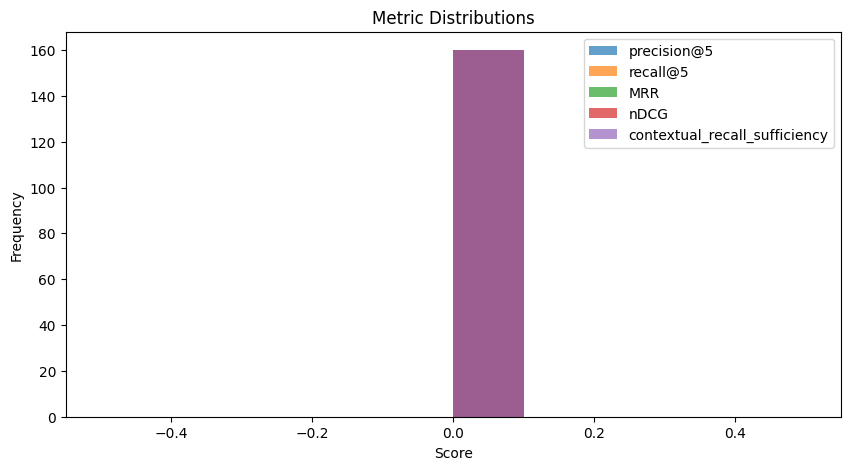

In [14]:
# Distribution Plots
metrics_df[[f"precision@{TOP_K}", f"recall@{TOP_K}", "MRR", "nDCG", "contextual_recall_sufficiency"]].plot.hist(alpha=0.7, bins=10, figsize=(10,5), title="Metric Distributions")
plt.xlabel("Score")
plt.show()

In [15]:
# Metrics by Topic or Level
if "topic" in golden_df.columns:
    merged = pd.concat([metrics_df, golden_df[["topic"]]], axis=1)
    topic_means = merged.groupby("topic").mean(numeric_only=True)
    topic_means.plot(kind="bar", figsize=(12,6), title="Metrics by Topic")
    plt.ylabel("Score")
    plt.show()

In [18]:
metrics_df.to_csv(f"../{METRICS_SUMMARY_FILE}", index=False)
print(f"Saved metrics summary to {METRICS_SUMMARY_FILE}")

Saved metrics summary to data/eval/metrics_summary.csv


In [22]:
for g, r in zip(golden, results):
    print("Query:", g.get("query"))
    print("Ground truth:", g.get("context_ids"))
    print("Retrieved:", r.get("retrieved_chunks"))
    print()


Query: What is the purpose of the Mars-Grunt mission?
Ground truth: ['chunk_0']
Retrieved: [5, 6, 4, 0, 3]

Query: What are the three distinct phases outlined in NASA's 'Journey to Mars' plan?
Ground truth: ['chunk_0']
Retrieved: [2, 3, 0, 1, 5]

Query: What are some alternate theories for the creation of surface gullies and channels on Mars?
Ground truth: ['chunk_1']
Retrieved: [1, 2, 0, 3, 0]

Query: How does CO2 ice accumulation contribute to gully formation on Mars according to the passage?
Ground truth: ['chunk_1']
Retrieved: [2, 1, 3, 0, 0]

Query: Which space probe was the first to explore Neptune directly?
Ground truth: ['chunk_2']
Retrieved: [0, 1, 3, 3, 6]

Query: What significant atmospheric feature did Voyager 2 discover on Neptune, which is similar to one on Jupiter?
Ground truth: ['chunk_2']
Retrieved: [1, 1, 0, 2, 5]

Query: What organization started officially approving names for moons in the late 1970s?
Ground truth: ['chunk_3']
Retrieved: [0, 0, 0, 1, 0]

Query: How d